**Setup**

In [4]:
import sys

assert sys.version_info >= (3, 7)

In [5]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [6]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

Verifique se existe uma GPU disponível

In [7]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

**Gymnasium**

In [8]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gymnasium swig
    %pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]

In [9]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array")

In [10]:
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['ALE/Adventure-ram-v5',
 'ALE/Adventure-v5',
 'ALE/AirRaid-ram-v5',
 'ALE/AirRaid-v5',
 'ALE/Alien-ram-v5',
 '...']

O Cart-Pole é um ambiente muito simples composto por um carrinho que pode se mover para a esquerda ou para a direita, e um poste colocado verticalmente em cima dele.

In [11]:
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

Vamos inicializar o ambiente chamando o método reset(). Isso retorna uma observação:

In [12]:
obs, info = env.reset(seed=42)
obs
# informações: posição horizontal do carrinho, velocidade, ângulo de inclinação do poste, ângulo de direção do poste (direita / esquerda)

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

As observações variam de acordo com o ambiente. Neste caso, é um array NumPy 1D composto por 4 números: a posição horizontal do carrinho, sua velocidade, o ângulo do poste (0 = vertical) e a velocidade angular.

In [13]:
info

{}

In [14]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

In [15]:
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

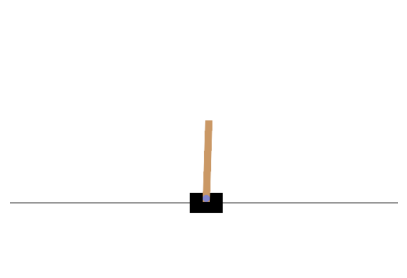

In [16]:
plot_environment(env)
plt.show()

Interagindo com o ambiente: o agente precisará selecionar uma ação de um "espaço de ação". Vamos ver como é o espaço de ação deste ambiente:

In [17]:
env.action_space

Discrete(2)

Apenas duas ações possíveis: acelerar para a esquerda ou para a direita.

Como o poste está inclinado para a direita (obs[2] > 0), vamos acelerar o carrinho para a direita:

In [18]:
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

Observe que o carrinho agora está se movendo para a direita (obs[1] > 0). O poste ainda está inclinado para a direita (obs[2] > 0), mas sua velocidade angular agora é negativa (obs[3] < 0), então provavelmente será inclinado para a esquerda após a próxima etapa.

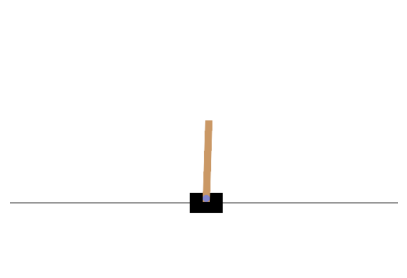

In [19]:
# extra code – displays the environment
plot_environment(env)
plt.show()

O ambiente também informa ao agente quanta recompensa ele recebeu durante a última etapa:

In [20]:
reward

1.0

Quando o jogo acaba, o ambiente retorna done=True:

In [21]:
done

False

Alguns wrappers de ambiente podem querer interromper o ambiente antecipadamente. Por exemplo, quando um limite de tempo é atingido ou quando um objeto sai dos limites. Neste caso, truncated será definido como True.

In [22]:
truncated

False

info é um dicionário específico do ambiente que pode fornecer algumas informações extras que podem ser úteis para depuração ou treinamento. Por exemplo, em alguns jogos pode indicar quantas vidas o agente tem.

In [23]:
info

{}

A sequência de passos entre o momento em que o ambiente é reiniciado até que seja concluído é chamado de "episódio". No final de um episódio (ou seja, quando step() retorna done=True), você deve redefinir o ambiente antes de continuar a usá-lo.

In [24]:
if done or truncated:
    obs, info = env.reset()

Agora, como podemos fazer o poste permanecer na posição vertical? Precisaremos definir uma política para isso. Essa é a estratégia que o agente usará para selecionar uma ação em cada etapa. Ele pode usar todas as ações e observações passadas para decidir o que fazer.

**Um exemplo de uma policy**

Uma estratégia simples: se o poste estiver inclinado para a esquerda, empurre o carrinho para a esquerda e vice-versa.

In [25]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)

In [26]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

Estratégia é um pouco básica demais: o melhor que ela fez foi manter o poste por apenas 63 passos. O cenário de vitória é quando o agente mantém o poste ativo por 200 passos.

Visualizando 1 episódio

In [27]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)

Sistema é instável e depois de apenas algumas oscilações, o poste acaba muito inclinado: game over.

**Neural Network Policies**

Para escolher uma ação, a rede estimará uma probabilidade para cada ação. Selecionaremos uma ação aleatoriamente de acordo com as probabilidades estimadas.

existem apenas duas ações possíveis (esquerda ou direita), então precisamos apenas de um neurônio de saída: ele produzirá a probabilidade “p” da ação 0 (esquerda) e a probabilidade de ação 1 (direita) será 1 - p.


In [28]:
import tensorflow as tf

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Aqui nosso problema é o mais simples possível: a observação atual é livre de ruído e contém o estado completo do ambiente (não precisamos analisar a ação passada para inferir a velocidade por exemplo).

Vamos escrever uma pequena função de política que usará a rede neural para obter a probabilidade de movimento para a esquerda e, em seguida, vamos usá-la para executar um episódio:



In [29]:
def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)[0][0]
    return int(np.random.rand() > left_proba)

np.random.seed(42)
show_one_episode(pg_policy)

Observe que o resultado não é nada bom. Primeiro vamos ver se ele é capaz de aprender a política básica que usamos anteriormente: vá para a esquerda se o poste estiver inclinando para a esquerda e vá para a direita se estiver inclinando para a direita.

**Gradiente de Política**

O algoritmo Policy Gradients reproduz vários episódios e, em seguida, tornando as ações em bons episódios um pouco mais prováveis, enquanto as ações em episódios ruins são um pouco menos prováveis.

Vamos começar criando uma função para executar uma única etapa usando o modelo. Também vamos fazer de conta por enquanto que qualquer ação tomada é a correta, para que possamos calcular a perda e seus gradientes (vamos apenas salvar esses gradientes por enquanto e modificá-los mais tarde, dependendo de quão boa ou ruim a ação acabou ser):

In [30]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

Se left_proba for alto, então action provavelmente será False (já que um número aleatório entre 0 e 1 provavelmente não será maior que left_proba). E False significa 0, então y_target seria igual a 1 - 0 = 1. Em outras palavras, definimos o alvo como 1, o que significa que fingimos que a probabilidade de ir para a esquerda deveria ter sido 100% (então tomamos a ação certa).

Agora vamos criar outra função que contará com a função play_one_step() para reproduzir vários episódios, retornando todas as recompensas e gradientes, para cada episódio e cada etapa:

In [31]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

O algoritmo Policy Gradients usa o modelo para reproduzir o episódio várias vezes, depois volta e analisa todas as recompensas, as desconta e as normaliza. Então, vamos criar duas funções para isso: a primeira calculará as recompensas com desconto; a segunda normalizará as recompensas com desconto em muitos episódios.

In [32]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Digamos que houvesse 3 ações e, após cada ação, houvesse uma recompensa: primeiro 10, depois 0, depois -50. Se usarmos um fator de desconto de 80%, a 3ª ação receberá -50 (crédito total para a última recompensa), mas a 2ª ação receberá apenas -40 (crédito de 80% para a última recompensa) e a 1ª ação receberá 80% de -40 (-32) mais crédito total para a primeira recompensa (+10), o que leva a uma recompensa com desconto de -22:

In [33]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

Para normalizar todas as recompensas com desconto em todos os episódios, calculamos a média e o desvio padrão de todas as recompensas com desconto, subtraímos a média de cada recompensa com desconto e dividimos pelo desvio padrão:

In [34]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

**Treinando o modelo**

In [35]:
n_iterations = 100
# O ideal é que tivessem mais de 200 iterações mas vamos processar com menor quantidades devido ao tempo de processamento
n_episodes_per_update = 10
# consideramos 10 episódios para evoluir o modelo, então depois de cada 10 jogos o objetivo é ter uma nova atualização em cima do nosso modelo
n_max_steps = 200
# pra cada jogo vamos jogar 200 etapas no maxímo
discount_factor = 0.95
# Fator de disconto

In [36]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

obs, info = env.reset(seed=42)

In [37]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

A cada iteração de treinamento, o loop abaixo chama a função play_multiple_episodes(), que reproduz o jogo 10 vezes e retorna todas as recompensas e gradientes para cada episódio e etapa.

Então chamamos o discount_and_normalize_rewards() para calcular a vantagem normalizada de cada ação (final_reward). Isso fornece uma medida de quão boa ou ruim cada ação realmente foi, em retrospectiva.

Em seguida, passamos por cada variável treinável e, para cada uma delas, calculamos a média ponderada dos gradientes dessa variável em todos os episódios e todas as etapas, ponderada pelo final_reward.

Por fim, aplicamos esses gradientes médios usando o otimizador: as variáveis ​​treináveis ​​do modelo serão ajustadas.



In [38]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py:291: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self._numpy())


Iteration: 100/100, mean rewards: 98.0

In [39]:
np.random.seed(42)
show_one_episode(pg_policy)

O algoritmo de gradientes de política simples resolveu a tarefa CartPole, mas não seria bem dimensionado para tarefas maiores e mais complexas.

De fato, é ineficiente em termos de amostra, o que significa que precisa explorar o jogo por muito tempo antes que possa fazer progressos significativos. Isso se deve ao fato de que ele deve executar vários episódios para estimar a vantagem de cada ação.

**Referência**

[Hands-on ML with Scikit-Learn, Keras & TF by Aurelien Geron](https://github.com/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb)